In [1]:
import functions as fn
import numpy as np
import matplotlib.pyplot as plt

In [15]:
Sim_period = 20000 # milliseconds
Sim_fs = 100  # samples per second

Sim_dt = 1/Sim_fs
Sim_t = np.arange(0, Sim_period, Sim_dt)

In [16]:
def expe(x):
    if (x == 0):
        expVal = 1
    else:
        expVal = (np.exp(x) - 1) / x
    
    return expVal

In [17]:
# variable = value xxx Unit
gNA = 240  # m.mho/cm^2
gK  = 36   # m.mho/cm^2
gA  = 61   # m.mho/cm^2
gL  = 0.068  # m.mho/cm^2
ENA = 64.7  # mV  +64.7 + 71   
EK  = -95.2  # mV  -95.2 + 71
EL  = -51.3 # mV  -51.3 + 71
C   = 1    # uF/cm^2
Er  = -71

# added inductor
g_L = 10000
L = 1

I_stim = .1

In [23]:
I = I_stim * np.ones(Sim_t.shape)  # pA

# Sinusoid
# I1 = fn.gen_sin(init_time=0,
#                 freq=1,
#                 phase=0,
#                 time_points=Sim_t)
# I2 = fn.gen_sin(init_time=50,
#                 freq=.01,
#                 phase=0,
#                 time_points=Sim_t)

# I = slope * (I_stim * (I3 * .1 + I2 * 1) + 0)




# sinusoid + chirp
I1 = fn.gen_sin(init_time=0,
                freq=1,
                phase=0,
                time_points=Sim_t)
I3, freq = fn.gen_chirp(Chirp_init_freq=1.001, 
                         Chirp_init_time=0, 
                         Chirp_end_freq=1.02, 
                         Chirp_end_time=Sim_t[-1], 
                         time_points=Sim_t)

freq *= 1000  # change from kHz to Hz
I = I_stim * (I1 + I3)

# Chirp stimulation
# out, freq = fn.gen_chirp(Chirp_init_freq=.0001, 
#                          Chirp_init_time=0, 
#                          Chirp_end_freq=.02, 
#                          Chirp_end_time=Sim_t[-1], 
#                          time_points=Sim_t)

# I      = I_stim * out  # pA

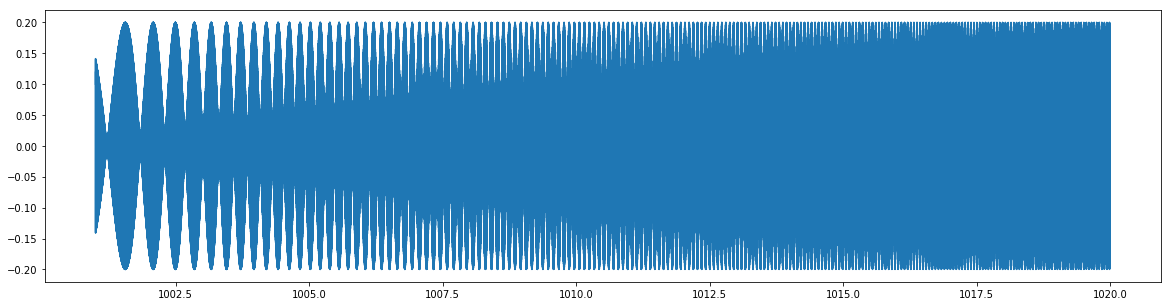

In [24]:
plt.figure(figsize=(20,5))
plt.plot(freq, I)

In [25]:
# Other initialization
# Na channel
m = np.zeros(Sim_t.shape)
h = np.zeros(Sim_t.shape)

# delayed-rectifier K current
n = np.zeros(Sim_t.shape)

# slow non-inactivating K current
p = np.zeros(Sim_t.shape)
a = np.zeros(Sim_t.shape);
b = np.zeros(Sim_t.shape);

u    = np.ones(Sim_t.shape) * Er
INA  = np.zeros(Sim_t.shape)
IK  = np.zeros(Sim_t.shape)
IA   = np.zeros(Sim_t.shape)
I_L   = np.zeros(Sim_t.shape)

In [26]:
for i in range(I.shape[0]-1):

    aM = 11.3/expe((-53-u[i])/6)
    bM = 37.4/expe((57+u[i])/9)
    aH = 5/expe((u[i]+106)/9)
    bH = 22.6/(np.exp((-22-u[i])/12.5)+1)
    
    n_inf  = 1/(1 + np.exp((1.7-u[i])/11.4))
    tau_n  = 0.24 + 0.7/(1 + np.exp((u[i] + 12)/16.4))
    
    a_inf  = 1/(1+np.exp((-55-u[i])/13.8))
    b_inf  = 1/(1+np.exp((77+u[i])/7.8))
    tau_a  = 0.12 + 0.6/(1+np.exp((u[i]+24)/16.5))
    tau_b  = 2.1 + 1.8/(1+np.exp((u[i]-18)/5.7))
    
    tau_m  = 1/(aM + bM)
    m_inf  = aM * tau_m
    
    tau_h  = 1/(aH + bH)
    h_inf  = aH * tau_h
    
    # Update the gating variables
    n[i+1] = ((n_inf - n[i])/tau_n) * Sim_dt + n[i]
    a[i+1] = ((a_inf - a[i])/tau_a) * Sim_dt + a[i]
    b[i+1] = ((b_inf - b[i])/tau_b) * Sim_dt + b[i]
    m[i+1] = ((m_inf - m[i])/tau_m) * Sim_dt + m[i]
    h[i+1] = ((h_inf - h[i])/tau_h) * Sim_dt + h[i]
    
    # Compute the currents
    INA[i] = gNA * (m[i]**3) * h[i] * (ENA-u[i])
    IK[i] = gK * (n[i]**3) * (EK-u[i])
    IA[i] = gA * (a[i]**4) * b[i] * (EK-u[i])
    IL = gL * (EL-u[i])
    
    # let's block some currents
#     I[i] = 0
#     INA[i] = 0  # contributing to the integration
#     IK[i] = 0  # not sure what is contributing to!
#     IA[i] = 0  # contributes to stability and bringing down the membrane potential (so integration as well)
    
    dudt = (INA[i] + IK[i] + IA[i] + IL + I[i]) / C
    u[i+1] = u[i] + Sim_dt * dudt

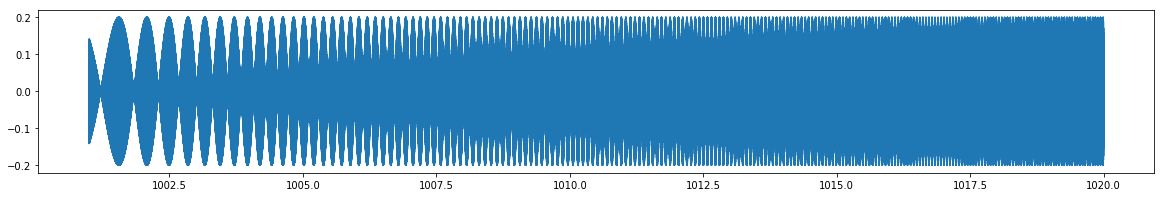

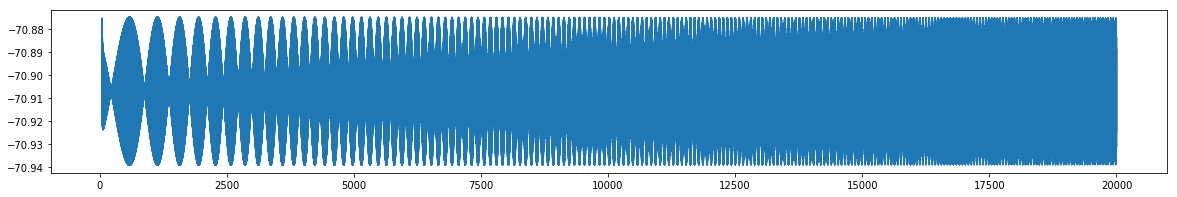

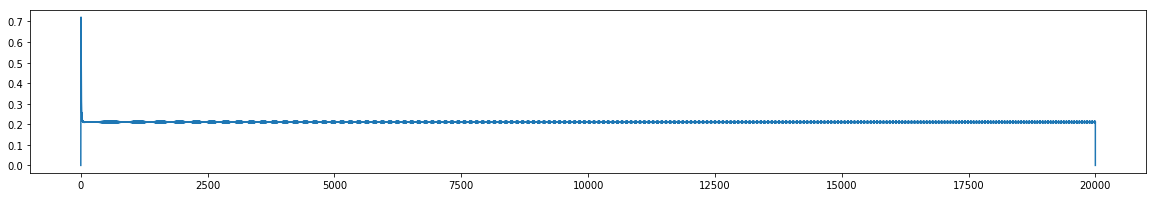

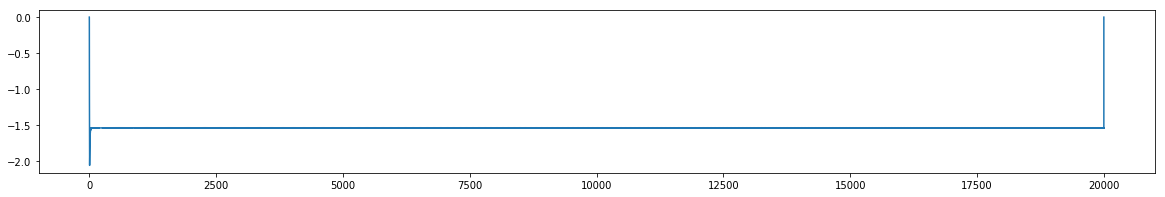

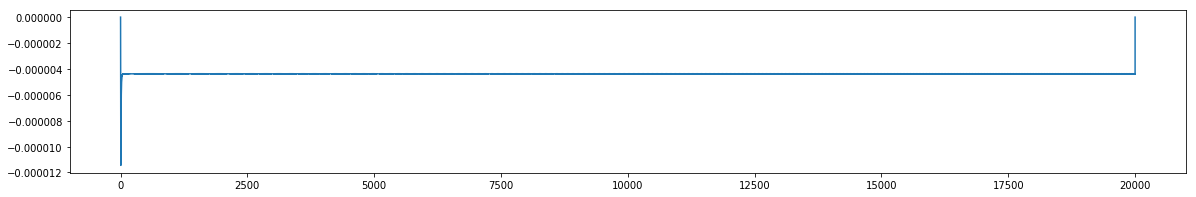

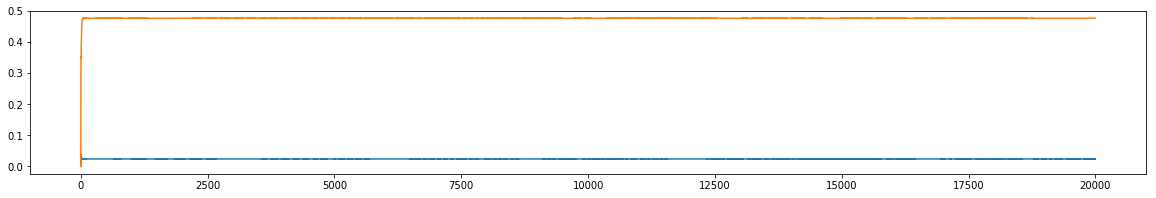

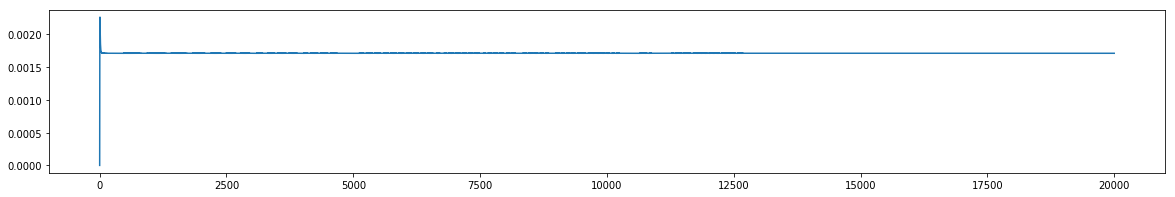

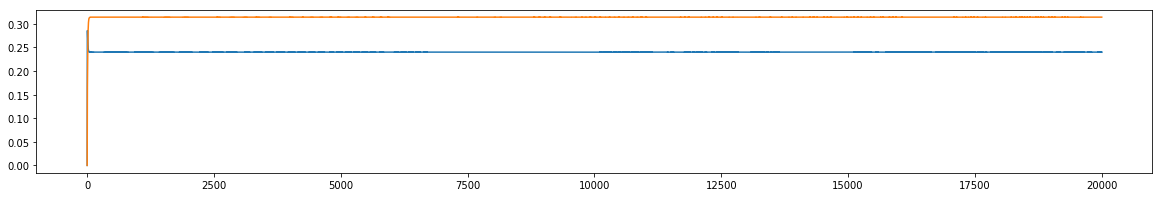

In [28]:
plt.figure(figsize=(20,3))
plt.plot(freq, I)
plt.show()

plt.figure(figsize=(20,3))
plt.plot(Sim_t[4500:], u[4500:])
plt.show()

plt.figure(figsize=(20,3))
plt.plot(Sim_t, INA)
plt.show()

plt.figure(figsize=(20,3))
plt.plot(Sim_t, IA)
plt.show()

plt.figure(figsize=(20,3))
plt.plot(Sim_t, IK)
plt.show()

# plt.figure(figsize=(20,3))
# plt.plot(Sim_t, I_L)
# plt.show()

plt.figure(figsize=(20,3))
plt.plot(Sim_t, m)
plt.plot(Sim_t, h)
plt.show()

plt.figure(figsize=(20,3))
plt.plot(Sim_t, n)
plt.show()

plt.figure(figsize=(20,3))
plt.plot(Sim_t, a)
plt.plot(Sim_t, b)
plt.show()

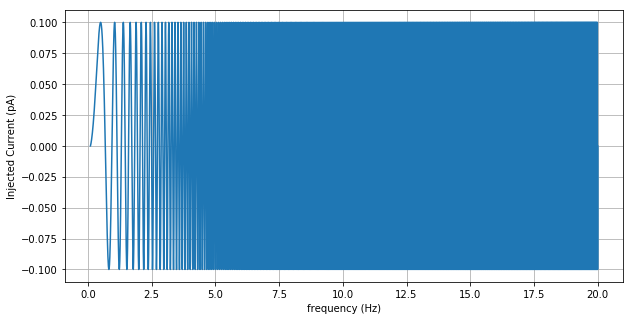

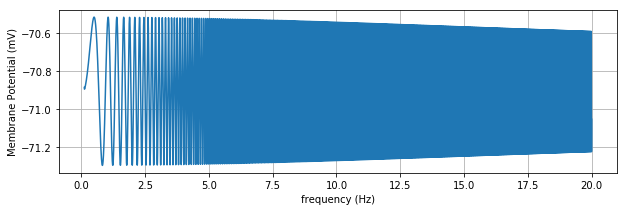

In [9]:
plt.figure(figsize=(10,5))
plt.plot(freq * 1000, I)
plt.xlabel('frequency (Hz)')
plt.ylabel('Injected Current (pA)')
plt.grid()
# plt.savefig('D:\TUM\Semester 2 - Holidays\Research project\Project\Erratum\Figures\Paper Figures\First Draft\ZAP\InputZAP.png')
plt.show()

plt.figure(figsize=(10,3))
plt.xlabel('frequency (Hz)')
plt.ylabel('Membrane Potential (mV)')
plt.plot(freq[4500:] * 1000, u[4500:])
plt.grid()
# plt.savefig('D:\TUM\Semester 2 - Holidays\Research project\Project\Erratum\Figures\Paper Figures\First Draft\ZAP\MammHHZAP.png')
plt.show()

##  Adding an inductor to this model

First let's charactrize the response of this model and then see the response with an inductor.

We are look into the leak branch

In [ ]:
f = np.arange(0.01,1000,.01)  # Hz
w = 2 * np.pi * f

RL = 1 / gL

L = 1
R_L = .1 * 1000 # kOhm

z = (1j*w*C*1e-6 + gL*1e-3 + 1/(1j*w*L + R_L)) ** -1
z_amp = np.sqrt(z.real**2 + z.imag**2)

z_L = 1j*w*L + R_L
z_L_amp = np.sqrt(z_L.real**2 + z_L.imag**2)

z_C = (1j*w*C*1e-6 + gL*1e-3) ** -1
z_C_amp = np.sqrt(z_C.real**2 + z_C.imag**2)

print('time constant: ', (C)/(gL))

plt.figure(figsize=(20,5))
plt.loglog(f, z_amp)
plt.loglog(f, z_L_amp)
plt.loglog(f, z_C_amp)
plt.grid()
plt.show()